In [171]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/d2d_channelprediction'
%mkdir '/content/drive/My Drive/d2d_channelprediction' -p
%cd '/content/drive/My Drive/d2d_channelprediction'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/d2d_channelprediction


In [183]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob
import pdb

from dateutil.relativedelta import relativedelta

In [184]:
class DataLoader:
  def __init__(self, path="data/", split='train'):
    self.path = path
    self.split = split
    ts_raw = pd.read_csv(os.path.join(path,f'{split}_d2d.csv')).iloc[:,1:].values.astype(np.float32)
    self.ts_raw = []
    
    for ts in ts_raw:
      self.ts_raw.append(ts[~np.isnan(ts)])


    self.ts_weight = np.zeros((len(self.ts_raw),), dtype=np.float32)
    for i,ts in enumerate(self.ts_raw):
      self.ts_weight[i] = len(ts)
    self.ts_weight = self.ts_weight / self.ts_weight.sum()

  def get_batch(self, batch_size=264, win_len=14*2, horizon=12, ts_sampling='uniform'):
  
    target_ts = np.zeros((batch_size, horizon), dtype=np.float32)
    history_ts = np.zeros((batch_size, win_len), dtype=np.float32)

    if ts_sampling == "uniform":
        ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True)
    elif ts_sampling == "ts_weight":
        ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True, p=self.ts_weight)
        
    for i, ts_id in enumerate(ts_idxs):
        ts = self.ts_raw[ts_id]
        sampling_point = np.random.choice(np.arange(win_len, len(ts)-horizon+1), size=1, replace=False)[0]
        history_ts[i,:] = ts[sampling_point-win_len:sampling_point]
        target_ts[i,:] = ts[sampling_point:sampling_point+horizon]

    batch = {"history": history_ts, "target": target_ts}
    return batch

  def get_sequential_batch(self, win_len=14*2):
    history_ts = np.zeros((len(self.ts_raw), win_len), dtype=np.float32)
    for i, ts in enumerate(self.ts_raw):
        history_ts[i,:] = ts[-win_len:]
    return {"history": history_ts}

train_dataset = DataLoader(path='data', split='train')
test_dataset = DataLoader(path='data', split='test')

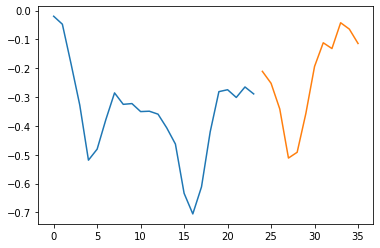

In [185]:
win_len=12*2
batch = train_dataset.get_batch(win_len=win_len, batch_size = 64)

plt.plot(batch["history"][0])
plt.plot(np.concatenate([np.nan*np.zeros((win_len,)), batch["target"][0]]))

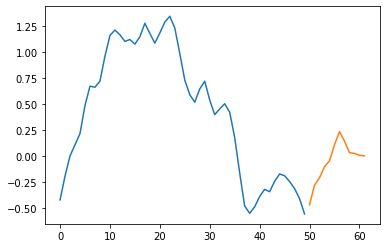

In [210]:
batch = train_dataset.get_sequential_batch()
id = 0
nsamples = 50

plt.plot(train_dataset.ts_raw[id][-nsamples:])
plt.plot(np.concatenate([np.nan*np.zeros((nsamples,)), test_dataset.ts_raw[id]]))

In [295]:
class Parameters(NamedTuple):
    split: int
    repeat: int
    epochs: int
    steps_per_epoch: int
    block_layers: int
    hidden_units: int
    num_blocks: int
    block_sharing: bool
    horizon: int
    history_lookback: int
    init_learning_rate: float
    decay_steps: int
    decay_rate: float
    loss: str
    pinball_tau: float
    batch_size: int
    weight_decay: float
    ts_sampling: str
        
hyperparams_dict = {
    "split": 1, # 0 is test split, 1 is validation split
    "repeat": list(range(0, 1)),
    "epochs": 20, 
    "steps_per_epoch": [50], 
    "block_layers": [3],
    "hidden_units": 512,
    "num_blocks": 3,
    "block_sharing": True, # [True, False]
    "horizon": 12,
    "history_lookback": 2,
    "init_learning_rate": 1e-3,
    "decay_steps": 3,
    "decay_rate": 0.5,
    "loss": ["pinball", "pmape"], # ["pinball", "mape", "smape", "pmape"]
    "pinball_tau": [0.35], # This is selected to minimize the bias on the validation set
    "batch_size": 256,
    "weight_decay": 0,
    "ts_sampling": ["ts_weight"], # ["uniform", "ts_weight"]
}

HORIZON = 12

hyperparams = Parameters(**hyperparams_dict)

In [296]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, hyperparams: Parameters, input_size:int, output_size:int, **kw):
        super(NBeatsBlock, self).__init__(**kw)
        self.hyperparams = hyperparams
        self.input_size = input_size
        self.output_size = output_size
        self.fc_layers = []
        for i in range(hyperparams.block_layers):
            self.fc_layers.append(
                tf.keras.layers.Dense(hyperparams.hidden_units, 
                                      activation=tf.nn.relu,
                                      kernel_regularizer=tf.keras.regularizers.l2(hyperparams.weight_decay),
                                      name=f"fc_{i}")
            )
        self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")
        self.backcast = tf.keras.layers.Dense(self.input_size, activation=None, name="backcast")        
        
    def call(self, inputs, training=False):
        h = self.fc_layers[0](inputs)
        for i in range(1, self.hyperparams.block_layers):
            h = self.fc_layers[i](h)
        backcast = tf.keras.activations.relu(inputs - self.backcast(h))

        return backcast, self.forecast(h)

In [297]:
class NBeats:
    def __init__(self, hyperparams: Parameters, name: str='NBeats', logdir: str='logs', num_nodes: int = 100):
        super(NBeats, self).__init__()
        self.hyperparams = hyperparams
        self.name=name
        self.logdir=logdir
        self.num_nodes = num_nodes
        self.input_size = self.hyperparams.history_lookback*self.hyperparams.horizon

        self.nbeats_layers = []
        self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                                  input_size=self.input_size, 
                                                  output_size=hyperparams.horizon, 
                                                  name=f"nbeats_{0}")
                                      )
        for i in range(1, hyperparams.num_blocks):
            if self.hyperparams.block_sharing:
                self.nbeats_layers.append(self.nbeats_layers[0])
            else:
                self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                                    input_size=self.input_size, 
                                                    output_size=hyperparams.horizon, 
                                                    name=f"nbeats_{i}")
                                        )

        inputs, outputs = self.get_model()
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
        self.inputs = inputs
        self.inputs = outputs
        self.model = model
                
    def get_model(self):
        history_in = tf.keras.layers.Input(shape=(self.hyperparams.history_lookback*self.hyperparams.horizon,), name='history')

        level = tf.reduce_max(history_in, axis=-1, keepdims=True)
        history_delevel = tf.math.divide_no_nan(history_in, level)

        backcast, forecast = self.nbeats_layers[0](inputs=history_delevel)
        for nb in self.nbeats_layers[1:]:
            backcast, forecast_layer = nb(inputs=backcast)
            forecast = forecast + forecast_layer

        forecast = forecast * level 

        inputs = {'history': history_in} 
        outputs = {'target': forecast}
        return inputs, outputs

    def forecast(self, train_dataset):
        input_data = train_dataset.get_sequential_batch(win_len=self.hyperparams.horizon*self.hyperparams.history_lookback)
        return self.model.predict({"history": input_data["history"]})['target']

In [298]:
def smape(labels, preds):
  weights = tf.stop_gradient(
    tf.math.divide_no_nan(2.0, (tf.abs(preds) + tf.abs(labels))))
  return tf.reduce_mean(tf.abs(preds - labels) * weights)

def mape(labels, preds):
  weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
  return tf.reduce_mean(tf.abs(preds - labels) * weights)

def get_pmape_loss(tau):
  def pmape_loss(labels, preds):
    weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
    pinball = tf.where(labels > preds,
                        x=tau*(labels - preds), 
                        y=(1-tau)*(preds-labels))
    return tf.reduce_mean(pinball * weights)
  return pmape_loss

def get_pinball_loss(tau):
  def pinball_loss(labels, preds):
    pinball = tf.where(labels > preds,
                        x=tau*(labels - preds), 
                        y=(1-tau)*(preds-labels))
    return tf.reduce_mean(pinball)
  return pinball_loss

def rmse(labels, preds):
  return tf.sqrt(tf.reduce_mean((preds - labels)**2))

def mae(labels, preds):
  return tf.reduce_mean(tf.abs(preds - labels))


class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_dataset, test_dataset, hyperparams):
        super().__init__()
        self.input_data = train_dataset.get_sequential_batch(win_len=hyperparams.horizon*hyperparams.history_lookback)
        self.target = np.array(test_dataset.ts_raw)

    def on_train_begin(self, logs={}):
        pass    

    def on_epoch_end(self, epoch, logs={}):
        prediction_test = self.model.predict({"history": self.input_data["history"]})
        logs['smape_test'] = smape(preds=prediction_test['target'], labels=self.target)
        logs['mape_test'] = mape(preds=prediction_test['target'], labels=self.target)

class Trainer:
    def __init__(self, hyperparams: Parameters, logdir: str):
        inp = dict(hyperparams._asdict())
        values = [v if isinstance(v, list) else [v] for v in inp.values()]
        self.hyperparams = [Parameters(**dict(zip(inp.keys(), v))) for v in product(*values)]
        inp_lists = {k: v  for k, v in inp.items() if isinstance(v, list)}
        values = [v for v in inp_lists.values()]
        variable_values = [dict(zip(inp_lists.keys(), v)) for v in product(*values)]
        folder_names = []
        for d in variable_values: 
            folder_names.append(
                ';'.join(['%s=%s' % (key, value) for (key, value) in d.items()])
            )
        self.history = []
        self.forecasts = []
        self.models = []
        self.logdir = logdir
        self.folder_names = folder_names
        for i, h in enumerate(self.hyperparams): 
            self.models.append(NBeats(hyperparams=h, name=f"nbeats_model_{i}", 
                                      logdir=os.path.join(self.logdir, folder_names[i])))
            
    def generator(self, ds, hyperparams: Parameters):
        while True:
            batch = ds.get_batch(batch_size=hyperparams.batch_size, 
                                 win_len=hyperparams.horizon*hyperparams.history_lookback, 
                                 horizon=hyperparams.horizon,
                                 ts_sampling=hyperparams.ts_sampling)

            yield  {"history": batch["history"]}, {"target": batch["target"]}

    def save_forecast(self, forecast: np.ndarray, filename: str = "forecast.npy"):
        np.save(f"{WORKING_PATH}/{filename}", forecast)
                            
    def fit(self, train_dataset, test_dataset, verbose=1):
        for i, hyperparams in enumerate(self.hyperparams):
            if verbose > 0:
                print(f"Fitting model {i+1} out of {len(self.hyperparams)}, {self.folder_names[i]}")

            path = f"results/{MODEL_VERSION}_split{self.models[i].hyperparams.split}/"
            pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
            filename = os.path.join(path, self.folder_names[i]+'.npy')
            if os.path.exists(f"{WORKING_PATH}/{filename}"):
                continue
            
            boundary_step = hyperparams.epochs // 10
            boundary_start = hyperparams.epochs - boundary_step*hyperparams.decay_steps - 1
            
            boundaries = list(range(boundary_start, hyperparams.epochs, boundary_step))
            values = list(hyperparams.init_learning_rate * hyperparams.decay_rate ** np.arange(0, len(boundaries)+1))
            scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=boundaries, values=values)
            
            lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

            metrics = MetricsCallback(train_dataset=train_dataset, test_dataset=test_dataset, hyperparams=hyperparams)
            # tb = tf.keras.callbacks.TensorBoard(log_dir=self.models[i].logdir, embeddings_freq=10)

            if hyperparams.loss == 'smape':
                loss = smape
            elif hyperparams.loss == 'mape':
                loss = mape
            elif hyperparams.loss == 'mae':
                loss = mae
            elif hyperparams.loss == 'pmape':
                loss = get_pmape_loss(hyperparams.pinball_tau)
            elif hyperparams.loss == 'pinball':
                loss = get_pinball_loss(hyperparams.pinball_tau)
            
            self.models[i].model.compile(optimizer=tf.keras.optimizers.Adam(),
                                         loss=loss)
                                    
            fit_output = self.models[i].model.fit(self.generator(ds=train_dataset, hyperparams=hyperparams),
                                            callbacks=[lr, metrics], # tb
                                            epochs=hyperparams.epochs, 
                                            steps_per_epoch=hyperparams.steps_per_epoch, 
                                            verbose=verbose)
            self.history.append(fit_output.history)

            model_forecast = self.models[i].forecast(train_dataset)
            self.save_forecast(forecast=model_forecast, filename=filename)


In [299]:
trainer = Trainer(hyperparams=hyperparams, logdir=LOGDIR)
trainer.fit(train_dataset=train_dataset, test_dataset=test_dataset)

Fitting model 1 out of 2, repeat=0;steps_per_epoch=50;block_layers=3;loss=pinball;pinball_tau=0.35;ts_sampling=ts_weight
Epoch 1/20
50/50 [==============================] - 6s 105ms/step - loss: 0.3584 - lr: 0.0010 - smape_test: 1.3547 - mape_test: 5.4649
Epoch 2/20
50/50 [==============================] - 5s 101ms/step - loss: 0.2831 - lr: 0.0010 - smape_test: 1.4648 - mape_test: 5.2328
Epoch 3/20
50/50 [==============================] - 5s 101ms/step - loss: 0.2683 - lr: 0.0010 - smape_test: 1.4504 - mape_test: 3.6684
Epoch 4/20
50/50 [==============================] - 5s 102ms/step - loss: 0.2544 - lr: 0.0010 - smape_test: 1.4477 - mape_test: 4.0627
Epoch 5/20
50/50 [==============================] - 5s 102ms/step - loss: 0.2555 - lr: 0.0010 - smape_test: 1.3762 - mape_test: 4.4402
Epoch 6/20
50/50 [==============================] - 5s 102ms/step - loss: 0.2603 - lr: 0.0010 - smape_test: 1.4437 - mape_test: 4.5041
Epoch 7/20
50/50 [==============================] - 5s 102ms/step - l

In [300]:
def get_forecasts(path, filt):
    a = []
    for f in tqdm(glob(os.path.join(WORKING_PATH, path, filt))):
        df = np.load(f)
        a.append(df)
    return a


def get_ensemble(forecasts):
    return np.mean(np.stack(forecasts, axis=-1), axis=-1)


def get_metrics(preds, labels):
    metrics = {}
    metrics["smape"] = 100*smape(preds=preds, labels=labels).numpy()
    metrics["mape"] = 100*mape(preds=preds, labels=labels).numpy()
    pe = 100*(preds-labels)/labels
    metrics["pe_mean"] = np.mean(pe)
    metrics["pe_median"] = np.median(pe)
    return metrics


def get_stats(samples=10, ensemble_size=64, test_dataset=None, config_filt=None, path=None):
    files = glob(os.path.join(WORKING_PATH, path, filt))
    all_repeats = set([int(f.split(os.sep)[-1].split(";")[0].split("=")[-1]) for f in files])
    preds = np.array(get_forecasts(path=path, filt=config_filt+".npy"))

    metric_samples = []
    ensemble_samples = []
    for s in range(samples):
        ensemble_repeats = np.random.choice(list(all_repeats), size=ensemble_size, replace=False)
        ensemble = preds[ensemble_repeats].mean(axis=0)
        metric_samples.append(get_metrics(preds=ensemble, labels=test_dataset.ts_raw))
        ensemble_samples.append(ensemble)

    return pd.DataFrame(metric_samples), ensemble_samples


def save_ensemble_files(path, ensembles):
    pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
    for i, e in enumerate(ensembles):
        filename = os.path.join(path, f"{i}.csv")
        df = pd.DataFrame(data=e, columns=[f"V{i+1}" for i in range(12)], index=[f"P{i+1}" for i in range(35)])
        df.to_csv(filename)

In [301]:
test_dataset.ts_raw[2]

array([ 0.070502, -0.12555 ,  0.12043 ,  0.38095 ,  0.3142  ,  0.056836,
       -0.29864 , -0.42217 , -0.082712,  0.15054 ,  0.052001,  0.      ],
      dtype=float32)

  0%|          | 0/2 [00:00<?, ?it/s]

MAE: 0.069098614
RMSE: 0.09372296


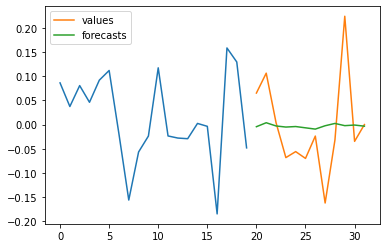

In [332]:
id = 3
nsamples = 20

MODEL_VERSION = "TEST"
split=0
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)

print("MAE:", mae(preds=forecasts[0][id], labels=test_dataset.ts_raw[id]).numpy())
print("RMSE:", rmse(preds=forecasts[0][id], labels=test_dataset.ts_raw[id]).numpy())

plt.plot(train_dataset.ts_raw[id][-nsamples:])
# plt.plot(forecasts[0][id], label='forecasts');
# plt.plot(test_dataset.ts_raw[id], label='values');
plt.plot(np.concatenate([np.nan*np.zeros((nsamples,)), test_dataset.ts_raw[id]]), label='values')
plt.plot(np.concatenate([np.nan*np.zeros((nsamples,)), forecasts[0][id]]), label='forecasts')
plt.legend()

  0%|          | 0/2 [00:00<?, ?it/s]

MAE: 0.09817051
RMSE: 0.12741986


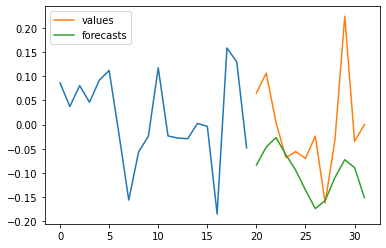

In [333]:
id = 3
nsamples = 20

MODEL_VERSION = "TEST"
split=0
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pinball*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)

print("MAE:", mae(preds=forecasts[0][id], labels=test_dataset.ts_raw[id]).numpy())
print("RMSE:", rmse(preds=forecasts[0][id], labels=test_dataset.ts_raw[id]).numpy())

plt.plot(train_dataset.ts_raw[id][-nsamples:])
# plt.plot(forecasts[0][id], label='forecasts');
# plt.plot(test_dataset.ts_raw[id], label='values');
plt.plot(np.concatenate([np.nan*np.zeros((nsamples,)), test_dataset.ts_raw[id]]), label='values')
plt.plot(np.concatenate([np.nan*np.zeros((nsamples,)), forecasts[0][id]]), label='forecasts')
plt.legend()

In [327]:
MODEL_VERSION = "TEST"
split=0
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)
a = get_ensemble(forecasts)

print("SMAPE:", 100*smape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAE:", mae(preds=a, labels=test_dataset.ts_raw).numpy())
print("RMSE:", rmse(preds=a, labels=test_dataset.ts_raw).numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

SMAPE: 158.14882516860962
MAPE: 100.45360326766968
MAE: 0.09807831
RMSE: 0.14503783


In [310]:
MODEL_VERSION = "TEST"
split=1
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pinball*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)
a = get_ensemble(forecasts)

print("SMAPE:", 100*smape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAE:", mae(preds=a, labels=test_dataset.ts_raw).numpy())
print("RMSE:", rmse(preds=a, labels=test_dataset.ts_raw).numpy())

  0%|          | 0/1 [00:00<?, ?it/s]

SMAPE: 126.04464292526245
MAPE: 391.25449657440186
MAE: 0.26799193
RMSE: 0.42617032


In [311]:
a[0]

array([-0.53964466, -0.47162753, -0.4494158 , -0.4036136 , -0.36169043,
       -0.30569103, -0.30133328, -0.21952805, -0.19918755, -0.23855759,
       -0.273859  , -0.26923424], dtype=float32)

In [312]:
test_dataset.ts_raw[0]

array([-0.47166 , -0.28346 , -0.21107 , -0.10588 , -0.049224,  0.10534 ,
        0.23358 ,  0.14283 ,  0.03069 ,  0.023102,  0.005563,  0.      ],
      dtype=float32)

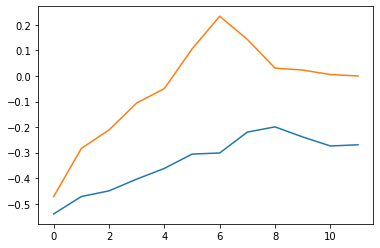

In [313]:
plt.plot(a[0])
plt.plot(test_dataset.ts_raw[0])

In [118]:
# ensemble_size = 64

# pinball_filt = "*steps_per_epoch=50*block_layers=3*loss=pinball*pinball_tau=0.35;ts_sampling=ts_weight*"
# metrics_pinball, ensembles_pinball = get_stats(samples=100, ensemble_size=ensemble_size, 
#                                                path=f"results/{MODEL_VERSION}_split{split}/", 
#                                                test_dataset=test_dataset,
#                                                config_filt=pinball_filt)

# print(f"PINBALL loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
# print(metrics_pinball.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# # Save ensemble files
# path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pinball_filt}"
# save_ensemble_files(path=path, ensembles=ensembles_pinball)


In [119]:
# pmape_filt = "*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"
# metrics_pmape, ensembles_pmape = get_stats(samples=100, ensemble_size=ensemble_size, 
#                                            path=f"results/{MODEL_VERSION}_split{split}/", 
#                                            test_dataset=test_dataset,
#                                            config_filt=pmape_filt)

# print(f"PMAPE loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
# print(metrics_pmape.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# # Save ensemble files
# path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pmape_filt}"
# save_ensemble_files(path=path, ensembles=ensembles_pmape)